In [1]:
"""
Created on Tue Sep 27 20:42:24 2022

@author: Clayton


This example illustrates the class design to sycronize data from two seperate acquisition devices.
"""

from CollateClasses import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
""" Set Parameters """

# set random seeed for reproducibility
np.random.seed(seed=42)

# Simulation parameters
seconds_of_data = 60
sys1_fs = 1000
sys2_fs = 2500
sys2_offset = 20

Text(0.5, 1.0, 'First 10 Clock Ticks')

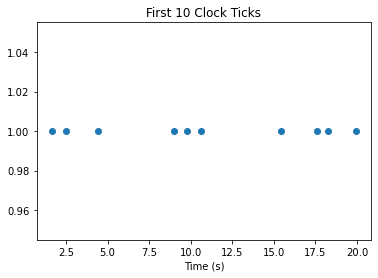

In [3]:
""" Simulate Clock Sequence """

clock = np.cumsum(np.random.lognormal(mean=0.0, sigma=1.0, size=1000))

plt.scatter(clock[:10],np.ones_like(clock[:10]))
plt.xlabel('Time (s)')
plt.title('First 10 Clock Ticks')

In [4]:
""" Define Class for System1 """

class System1(AcquisitionSystem):    
    def __init__(self,data_dir,system_name,samples_per_second):
        super().__init__(data_dir,system_name,samples_per_second)
    def load(self):
        # times each simulated sample is taken
        t = np.arange(seconds_of_data*sys1_fs)/sys1_fs
        # simulating data with noise for visualization
        sys1_data = t*np.sin(2*np.pi*t) + np.random.normal(0, 0.1, size=t.shape)
        # add this datasteram to our acquisition device
        meta_data = dict()
        self.add_data_stream(np.arange(seconds_of_data*sys1_fs),sys1_data,'sys1Data',meta_data)
        
        # get simulated clock times that fall into our observation window for this acquisition system
        sys1_clock_time = np.round(clock[clock<seconds_of_data]*sys1_fs)
        # add clock as datastream, make the "data" component ones of same shape as timestamps, since data field for timestamp data here is useless
        meta_data = dict()
        self.add_data_stream(sys1_clock_time,np.ones(sys1_clock_time.shape),'sys1Clock',meta_data)
        # add clock as our alignment datastream
        self.preprocess_alignment_data(self.data_streams.pop())
    def preprocess_alignment_data(self,alignment_data_stream):
        # This function is useful if any work needs to done to the clock signal to convert it to a timestamp, but here we don't have to
        self.alignment_data_stream = alignment_data_stream
    def preprocess(self):
        # nothing to preprocess since simulated data
        pass

In [5]:
""" Define Class for System2 """

class System2(AcquisitionSystem):  
    def __init__(self,data_dir,system_name,samples_per_second):
        super().__init__(data_dir,system_name,samples_per_second)
    def load(self): 
        # times each simulated sample is taken
        t = np.arange(seconds_of_data*sys2_fs)/sys2_fs+sys2_offset
        # simulating data with noise for visualization
        sys2_data = t*np.sin(2*np.pi*t) + np.random.normal(0, 0.1, size=t.shape)
        # add this datasteram to our acquisition device
        meta_data = dict()
        self.add_data_stream(np.arange(seconds_of_data*sys2_fs),sys2_data,'sys2Data',meta_data)
        
        # get simulated clock times that fall into our observation window for this acquisition system, and offset our times
        sys2_clock_time = np.round((clock[(clock>=sys2_offset) * (clock<seconds_of_data+sys2_offset)]-sys2_offset)*sys2_fs)
        # add clock as datastream, make the "data" component ones of same shape as timestamps, since data field for timestamp data here is useless
        meta_data = dict()
        self.add_data_stream(sys2_clock_time,np.ones(sys2_clock_time.shape),'sys2Clock',meta_data)
        # add clock as our alignment datastream
        self.preprocess_alignment_data(self.data_streams.pop())
    def preprocess_alignment_data(self,alignment_data_stream):
        # This function is useful if any work needs to done to the clock signal to convert it to a timestamp, but here we don't have to
        self.alignment_data_stream = alignment_data_stream
    def preprocess(self):
        # nothing to preprocess since simulated data
        pass

In [6]:
""" Create instances of acquistion devices """
system1 = System1('','System1',sys1_fs)
system2 = System2('','System2',sys2_fs)


In [7]:
""" create instance of experiment """
experiment = Experiment([system1,system2])

In [8]:
""" Normally, at this point you would just call the process() method to perform all the necessary steps. 
But here we call each step individually to illustrate the process."""

experiment._load_data()
experiment._preprocess_data()
experiment._create_data_dict()


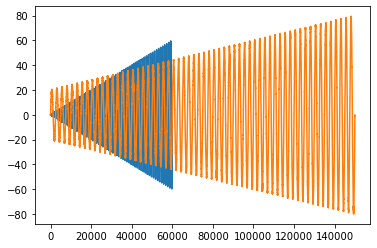

In [9]:
""" Showing unaligned data """
experiment.data_dict['sys1Data'].plot()
experiment.data_dict['sys2Data'].plot()


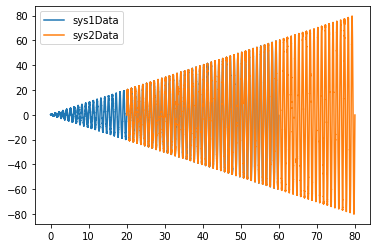

In [10]:
experiment._align_acquisition_systems()
experiment._create_data_dict()

experiment.data_dict['sys1Data'].plot()
experiment.data_dict['sys2Data'].plot()

plt.legend()

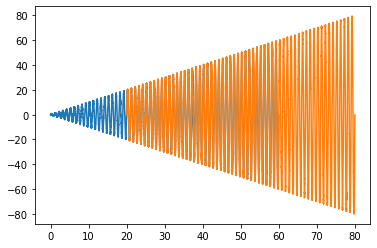

In [11]:
""" Typical Workflow """
system1 = System1('','System1',sys1_fs)
system2 = System2('','System2',sys2_fs)
experiment = Experiment([system1,system2])
experiment.process()
experiment.data_dict['sys1Data'].plot()
experiment.data_dict['sys2Data'].plot()